#                                            Apparel Recommendation




![link text](https://d3i71xaburhd42.cloudfront.net/dae7cb1a450e2e85899ef4272a7a73f0f369ebb0/10-Figure4-1.png)

### Imports

In [1]:
import json   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
 with open('/content/drive/My Drive/Dataset/tops_fashion.json') as f:
  data = json.load(f)

## Exploring the data

In [3]:
df = pd.DataFrame(data)
df = df.drop(['sku', 'author', 'publisher','availability', 'reviews', 'large_image_url','availability_type','small_image_url','editorial_review','model','manufacturer'], axis=1)
df.head()
del data

In [4]:
for i in range(10):
  print(df['title'][i]);
  plt.figure

Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women
FIG Clothing Womens Izo Tunic
FIG Clothing Womens Won Top
Focal18 Sailor Collar Bubble Sleeve Blouse Shirt Women Mori Girl Casual Top Harajuku
Featherlite Ladies' Long Sleeve Stain Resistant Tapered Twill Shirt, 2XL, Onyx Black/ Stone
[Fits Cloth] Grape Solid Modern Long Sleeve Plain T Shirt
Women's Unique 100% Cotton T - Special Olympics World Games 2015 White Size L
Floerns Women's Bell Sleeve Beading Casual Blouse Top
Standing on His Promises Rhinestones T-Shirt Ripped Cut Out Red Long
Fila Women's Tulip Durable Tennis Style Comfort Tank


In [5]:
print('Attributes in data')
for col in df.columns:
  print('->',col)
print('\nDuplicate in data, and nan values')  
for col in df.columns:
  print('-> Column: {}, Total values {}, unique values {}, nan values {}'.format(col, len(df[col]), len(set(list(df[col]))),sum(df[col].isnull().values)))  

Attributes in data
-> asin
-> product_type_name
-> formatted_price
-> color
-> brand
-> title
-> medium_image_url
-> editorial_reivew

Duplicate in data, and nan values
-> Column: asin, Total values 183138, unique values 183138, nan values 0
-> Column: product_type_name, Total values 183138, unique values 72, nan values 0
-> Column: formatted_price, Total values 183138, unique values 3136, nan values 154743
-> Column: color, Total values 183138, unique values 7381, nan values 118182
-> Column: brand, Total values 183138, unique values 10578, nan values 151
-> Column: title, Total values 183138, unique values 175985, nan values 0
-> Column: medium_image_url, Total values 183138, unique values 170782, nan values 0
-> Column: editorial_reivew, Total values 183138, unique values 128058, nan values 2758


## Recommendation on basis of titles of clothes
1. Remove all products with very few words in there title.
2. Sort the whole data based on title (alphabetical order of title),m and then remove titles that are very similar
3. using TFIDF(Term Frequency inverse document frequency) on Product titles to get an array representation as it gives less weightage to the words that appear often in the documents and focuses on words that are descriptive of the image

In [6]:
print('Total elements in the list: ', len(df))
print('Attributes of an apparel: ', list(df.columns))
print('Total null elements in formatter_price', sum(df['formatted_price'].isnull().values))

Total elements in the list:  183138
Attributes of an apparel:  ['asin', 'product_type_name', 'formatted_price', 'color', 'brand', 'title', 'medium_image_url', 'editorial_reivew']
Total null elements in formatter_price 154743


In [7]:
df = df.sort_values('title')
df.reset_index(drop = True, inplace = True)

In [8]:
df.head(2)

,asin,product_type_name,formatted_price,color,brand,title,medium_image_url,editorial_reivew
0,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,"""1984"" Retro Book Cover Women's SLim Fit T-Shi...",https://images-na.ssl-images-amazon.com/images...,
1,B071WD44WX,SHIRT,None,None,Sweet Claire,"""ASAP"" As Southern As Possible Tank Top, Heath...",https://images-na.ssl-images-amazon.com/images...,<p>THIS IS FOR THIS TANK IN HEATHER GREY WITH ...


### **Cleaning the texts**

### Remove duplicates in data

In [9]:
df = df.drop_duplicates(subset = 'medium_image_url').reset_index().drop(['index'],axis=1)
df = df.drop_duplicates(subset = 'title').reset_index().drop(['index'],axis=1)
print(len(df))

165698


### Remove null entries

In [10]:
df =df.loc[~df['color'].isnull()]
df =df.loc[~df['title'].isnull()]
df =df.loc[~df['formatted_price'].isnull()]
len(df)

18785

### Remove stop words

In [11]:
stopwrds = list(stopwords.words('english'))
l = list(df['title'])
for i in range(len(df['title'])):
  for j in range(len(stopwrds)):
    l[i] = l[i].replace(' '+stopwrds[j]+' ',' ')
df['title']=l

In [12]:
tokenizer = Tokenizer(oov_token="<UNK>") # if num words not provided it consider all
tokenizer.fit_on_texts(list(df['title']))      #this is a must, to give the tokenizer an idea of the train data
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(list(df['title']))
sequences[0]
tok_sent = tokenizer.sequences_to_texts(sequences)
df['title']=tok_sent

In [13]:
for col in df.columns:
  print('Column: {}, Total values {}, unique values {}, nan values {}'.format(col, len(df[col]), len(set(list(df[col]))),sum(df[col].isnull().values)))

Column: asin, Total values 18785, unique values 18785, nan values 0
Column: product_type_name, Total values 18785, unique values 54, nan values 0
Column: formatted_price, Total values 18785, unique values 2928, nan values 0
Column: color, Total values 18785, unique values 4243, nan values 0
Column: brand, Total values 18785, unique values 3534, nan values 55
Column: title, Total values 18785, unique values 18781, nan values 0
Column: medium_image_url, Total values 18785, unique values 18785, nan values 0
Column: editorial_reivew, Total values 18785, unique values 12691, nan values 282


In [14]:
df.reset_index(drop=True,inplace=True)
indices = list(df.index)
df.head(1)

,asin,product_type_name,formatted_price,color,brand,title,medium_image_url,editorial_reivew
0,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,1984 retro book cover women's slim fit t shirt...,https://images-na.ssl-images-amazon.com/images...,


* Removing titles that have are very similar

In [15]:
import itertools
deduped_idx = []
i = 0
j = 0 
while i < len(df) and j < len(df):
    previous_i = i
    a = df['title'].loc[i].split()
    j = i+1
    while j < len(df):
        b = df['title'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2: 
            deduped_idx.append(i)
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [16]:
df = df.iloc[deduped_idx]
df.reset_index(drop=True,inplace=True)
df.head(2)
list_titles = list(df['title'])
print(len(df))

16231


In [17]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vectorizer = CountVectorizer()
vectorizer
X = vectorizer.fit_transform(list_titles) #corpus is a list tof sentences
analyze = vectorizer.build_analyzer()

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list_titles)

In [20]:
def closestkrecom(idx,k):
  dist = sklearn.metrics.pairwise_distances( X, X[idx], metric='cosine')
  dist = np.squeeze(dist)
  #print(dist.shape)
  sort_idxs = np.random.choice(np.argsort(dist,axis=0)[1:],k)
  return sort_idxs

In [21]:
import random
import tensorflow as tf

In [22]:
for idx in random.sample(list(np.arange(len(df))), 20):
  print('-->  ', df['title'][idx])
  for j in closestkrecom(idx,5):
    print('   ',df['title'][j])
  print()

-->   bridal party pastel floral robe pink glitter style danirb bm fugl 1x 2x
    sexy summer sport halter tops digital printed women casual t shirt seawater small fresh
    bar iii sleeveless mock neck swing top black combo xxl
    bobeau women's small petite striped tank cami top brown ps
    kingyuan adjustable nipple clamps women men bondage sets couples flirt toy
    ms read women's contrast textured top 22 pale blue navy

-->   halston heritage sash halter top bone size medium
    official tummeow hang 2 art l large white t shirt women
    dsquared2 women's green 100 silk crewneck long sleeve blouse us s it 40
    stoosh women's juniors angel sleeve boxy crop top m dark coral
    focal18 paisley printed shirt mini dress blouse loose tops long sleeve novelty
    recycled karma women's medium tank unplugged blouse black m

-->   chic summer women emoji emotion cartoon sexy crop top casual short sleeveless
    esprit women's blue women's blouse made of soft fabric size l blue
    ro

## Recommendation on basis of image
* I am going to use an autoencoder and get a 2000 dimensional embedding
* Then 



![link text](https://miro.medium.com/max/3148/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)


### Imports and downloading the images

In [23]:
import os
from PIL import Image
import requests
from io import BytesIO
import skimage
from skimage import io
import urllib.request
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [24]:
path =  "/content/drive/My Drive/Apparel Reco"
try:
  os.makedirs('/content/Dataset/Train/Sample')                 #better than mkdir
except OSError:
  pass
try:
  os.makedirs('/content/Dataset/Test/Sample')                 #better than mkdir
except OSError:
  pass  

In [25]:
def download_images(df): #function to download all the images
  j=0
  o=0
  train,test = train_test_split(np.arange(len(df)), test_size=0.1, )
  for i in train:
    try:
      name = df['asin'][i] + ".jpg"
      print(name,', ',o)
      o+=1
      urllib.request.urlretrieve(df['medium_image_url'][i], "/content/Dataset/Train/Sample/"+ name)
    except:
      print("N/A",j)
      j+=1  
  for i in test:
    try:
      name = df['asin'][i] + ".jpg"
      print(name,', ',o)
      o+=1
      urllib.request.urlretrieve(df['medium_image_url'][i], "/content/Dataset/Test/Sample/"+ name)
    except:
      print("N/A",j)
      j+=1      
download_images(df)

Streaming output truncated to the last 5000 lines.
B075BSV439.jpg ,  11240
B01LXLM78T.jpg ,  11241
B00W873FDC.jpg ,  11242
B0732TXSCF.jpg ,  11243
B01112TBOQ.jpg ,  11244
B01N9P07NZ.jpg ,  11245
B01MG50IAB.jpg ,  11246
B014WD7XLO.jpg ,  11247
B073QWG1HV.jpg ,  11248
B017WSOZC6.jpg ,  11249
B012XYDPL6.jpg ,  11250
B074NB534S.jpg ,  11251
B0713Q513M.jpg ,  11252
B073TJCWXL.jpg ,  11253
B06XKBKYQC.jpg ,  11254
B0714J29WC.jpg ,  11255
B071DTL1WN.jpg ,  11256
B01KMK7UE6.jpg ,  11257
B00ZQ5WX6I.jpg ,  11258
B00ISDTCY6.jpg ,  11259
B01I6JM842.jpg ,  11260
B01N1GNCQK.jpg ,  11261
B004VT7N24.jpg ,  11262
B00I4T4OQU.jpg ,  11263
B071YCPGXR.jpg ,  11264
B01N6Q79AD.jpg ,  11265
B01BZZ76ZA.jpg ,  11266
B01ABAPQQ6.jpg ,  11267
B074HFRF11.jpg ,  11268
B00390KELS.jpg ,  11269
B017R04IT4.jpg ,  11270
B0021IWDEK.jpg ,  11271
B073THTTF1.jpg ,  11272
B01NGYEA1M.jpg ,  11273
B01J6M8C48.jpg ,  11274
B072Q2HDM9.jpg ,  11275
B071JW2MF4.jpg ,  11276
B01MAVTWYM.jpg ,  11277
B074VB3LTP.jpg ,  11278
B01FRPITNW.jp

In [26]:
def disp_img(idx): #this function displays image from idx in df
  response = requests.get(df['medium_image_url'][idx])
  img = Image.open(BytesIO(response.content))
  return img

In [27]:
def ur2arr(url, disp=False): #This takes in an url and convert it to array
  image_filename = url
  image_numpy = skimage.io.imread(image_filename)
  if disp:
    plt.imshow(image_numpy)
  return image_numpy

### Creating the Data Generators

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen  = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(                        #here we fit the data to the generator
        '/content/Dataset/Train',  # This is the source directory for training images
        target_size=(128, 128),  # All images will be resized to 150x150, no need to provide the channel dimension
        batch_size=64,           #labels are automatically assigned on basis of the directory they are in
        class_mode='input')
test_generator = test_datagen.flow_from_directory(                          #here we fit the data to the generator
        '/content/Dataset/Test',  # This is the source directory for test images
        target_size=(128, 128),  # All images will be resized to 150x150, no need to provide the channel dimension
        batch_size=128,           #labels are automatically assigned on basis of the directory they are in
        class_mode='input')

Found 14578 images belonging to 1 classes.
Found 1622 images belonging to 1 classes.


### Building the model

In [29]:
input_img = tf.keras.layers.Input(shape=(128, 128, 3))  # adapt this if using `channels_first` image data format
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoder = tf.keras.Model(input_img, tf.keras.layers.Flatten()(encoded))
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (1, 1), activation='relu')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = tf.keras.layers.UpSampling2D((1, 1))(x)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()
opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)        

### Training the model

In [30]:
opt = tf.keras.optimizers.Adam(0.01)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
history = autoencoder.fit(train_generator,
                epochs=10,
                validation_data=test_generator
                #callbacks=[tf.keras.callbacks.LearningRateScheduler(lrs)]
                )

Epoch 1/10
228/228 [==============================] - 19s 83ms/step - loss: 0.3424 - val_loss: 0.3021
Epoch 2/10
228/228 [==============================] - 18s 80ms/step - loss: 0.2948 - val_loss: 0.2933
Epoch 3/10
228/228 [==============================] - 18s 79ms/step - loss: 0.2903 - val_loss: 0.2900
Epoch 4/10
228/228 [==============================] - 18s 80ms/step - loss: 0.2860 - val_loss: 0.2887
Epoch 5/10
228/228 [==============================] - 18s 79ms/step - loss: 0.2840 - val_loss: 0.2877
Epoch 6/10
228/228 [==============================] - 18s 80ms/step - loss: 0.2862 - val_loss: 0.3174
Epoch 7/10
228/228 [==============================] - 18s 79ms/step - loss: 0.2864 - val_loss: 0.2853
Epoch 8/10
228/228 [==============================] - 18s 80ms/step - loss: 0.2845 - val_loss: 0.2963
Epoch 9/10
228/228 [==============================] - 18s 79ms/step - loss: 0.2842 - val_loss: 0.2855
Epoch 10/10
228/228 [==============================] - 18s 79ms/step - loss: 0.280

### Image Reconstruction quality check

In [34]:
x_test = next(iter(test_generator))
x_test[1].shape

(128, 128, 128, 3)

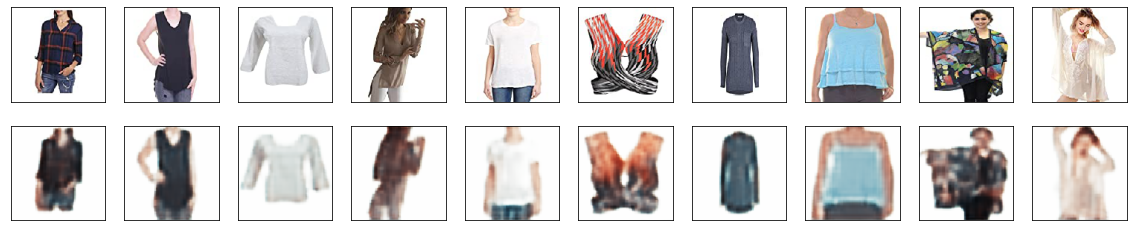

In [36]:
x_test = next(iter(test_generator))[0]
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n+1):
    if i==0:
      continue
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [41]:
os.listdir('/content/Dataset/Train/Sample')
p = {}
t=0
for filename in os.listdir('/content/Dataset/Train/Sample'):
  img = cv2.imread(os.path.join('/content/Dataset/Train/Sample',filename))
  img = cv2.resize(img, (128,128))
  img = np.expand_dims(img,0)
  p[filename] = encoder.predict(img)
  t+=1
  print(t)

Streaming output truncated to the last 5000 lines.
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769

In [42]:
t=0
for filename in os.listdir('/content/Dataset/Test/Sample'):
  img = cv2.imread(os.path.join('/content/Dataset/Test/Sample',filename))
  img = cv2.resize(img, (128,128))
  img = np.expand_dims(img,0)
  p[filename] = encoder(img)
  t+=1
  print(t)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [73]:
from PIL import Image as PImage
from matplotlib import rcParams

def disp(l):
  k= len(l)
  rcParams['figure.figsize'] = 11.7,8.27
  for i,filename in enumerate(l): 
    plt.figure(figsize =(3,3))
    try:
      img = PImage.open('/content/Dataset/Test/Sample/' + filename)
      plt.imshow(img)
    except:
      if(i==0):
       plt.title('Chosen Apparel')
      # print(df['title'][i])
      else:
        plt.title('Recommended Apparels') 
        #plt.title((df['title'][i]))
      img = PImage.open('/content/Dataset/Train/Sample/' + filename)
      plt.imshow(img)

In [44]:
from scipy.spatial import distance
def closestkrecom(idx,k):
  asin = df.iloc[idx]['asin'] + '.jpg'
  q={}
  arr = np.squeeze(p[asin])
  for key, value in p.items():
    dist = distance.cosine(arr,np.squeeze(value))
    q[key] = dist
  q = {value:key for key,value in q.items() } 
  l=[]
  for j,i in enumerate(sorted(q)): 
    if j== k:
      break  
    l.append(str(q[i])) 
  return l 

In [57]:
temp

15746

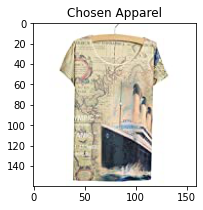

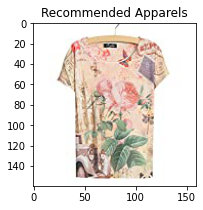

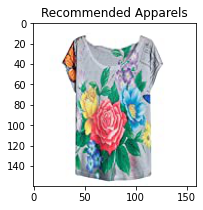

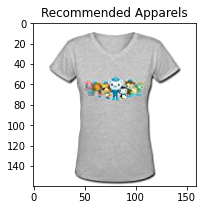

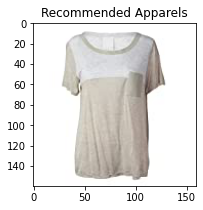

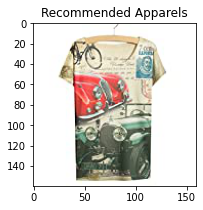

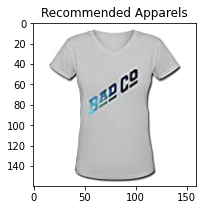

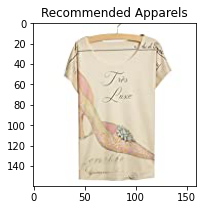

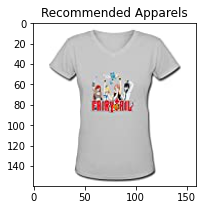

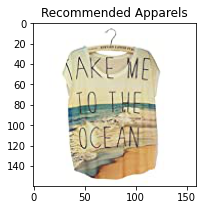

In [74]:
temp = random.randint(0,len(df))
l = closestkrecom(temp,10)
disp(l)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<UNK>") 
tokenizer.fit_on_texts(list_titles)
word_index = tokenizer.word_index
vocab_len = len(word_index)
def sentence2indices(sentences):
  sequences = tokenizer.texts_to_sequences(sentences)
  padded = pad_sequences(sequences, maxlen=7, padding = 'post', truncating = 'post')
  return padded
import tensorflow as tf
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_len, 32, input_length=7),
                             tf.keras.layers.LSTM(32),
                             tf.keras.layers.Dense(32)])
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(sentence2indices(list_titles),)